<a href="https://colab.research.google.com/github/Mohamedragih1/Stanford-Sentiment-Treebank-SST-Text-Classification/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loading

In [75]:
#Import required libraries
import numpy as np
!pip install datasets
from datasets import load_dataset
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [ ]:
#Load data
dataset = load_dataset("sst")

#Preprocessing

In [77]:
def rangeToCat(value):
    mappingFn = {
        (0, 0.2): 0,
        (0.2, 0.4): 1,
        (0.4, 0.6): 2,
        (0.6, 0.8): 3,
        (0.8, 1.0): 4
    }

    for range_, category in mappingFn.items():
        if range_[0] <= value <= range_[1]:
            return category
    else:
        return "Undefined range!"

In [78]:
#extract train, validation and test data
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [79]:
labels = train_data["label"]
train_labels = []
for label in labels:
  train_labels.append(rangeToCat(label))

In [80]:
labels = val_data["label"]
val_labels = []
for label in labels:
  val_labels.append(rangeToCat(label))

In [81]:
labels = test_data["label"]
test_labels = []
for label in labels:
  test_labels.append(rangeToCat(label))

# Feature generation functions

In [82]:
# tokenizing sentences bby spliting
def tokenize(sentence):
  return sentence.split()

# Get all possible bigrams from given sentence
def generateBigrams(sentence):
  words = tokenize(sentence)
  return [(words[i + 1], words[i]) for i in range(len(words)-1)]

# Generating features for the training set
def trainFeatures(dataset):
  total_bigrams = set()
  for example in dataset:
        bigrams = generateBigrams(example['sentence'])
        total_bigrams.update(bigrams)

  bi_gram_to_index = {bi_gram: index for index, bi_gram in enumerate(total_bigrams)}

  features = np.zeros((len(dataset), len(total_bigrams)))

  for i, example in enumerate(dataset):
    bigrams = generateBigrams(example['sentence'])
    for bi_gram in bigrams:
      index = bi_gram_to_index.get(bi_gram)
      if index is not None:
        features[i, index] = 1

    return features, total_bigrams

# Generating features for validation and test sets
def nonTrainFeatures(dataset, total_bigrams):
    bi_gram_to_index = {bi_gram: index for index, bi_gram in enumerate(total_bigrams)}

    features = np.zeros((len(dataset), len(total_bigrams)))

    for i, example in enumerate(dataset):
        bigrams = generateBigrams(example['sentence'])
        for bi_gram in bigrams:
            index = bi_gram_to_index.get(bi_gram)
            if index is not None:
                features[i, index] = 1

    return features

# Features Representaion

In [83]:
train_features, bigrams = trainFeatures(train_data)

In [84]:
val_features = nonTrainFeatures(val_data, bigrams)
test_features = nonTrainFeatures(test_data, bigrams)

In [85]:
print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

(8544, 87249)
(1101, 87249)
(2210, 87249)


In [86]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [87]:
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(8544,)
(1101,)
(2210,)


In [88]:
# converting features from float32 to int16
train_features = np.array(train_features,dtype = np.int16)
val_features = np.array(val_features,dtype = np.int16)
test_features = np.array(test_features,dtype = np.int16)

#Model building

In [89]:
# softmax function to return probability of each class
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [90]:
class LogisticRegression:
    def __init__(self, learning_rate, num_epochs, batch_size):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.num_classes = 5

    def fit(self, X, y):
      n_samples, n_features = X.shape

      self.weights = np.zeros((n_features, self.num_classes))
      self.bias = np.zeros(self.num_classes)

      for epoch in range(self.num_epochs):
          X, y = shuffle(X, y)
          for start in range(0, n_samples, self.batch_size):
            end = min(start + self.batch_size, n_samples)
            X_batch = X[start:end]
            y_batch = y[start:end]
            scores = np.dot(X_batch, self.weights) + self.bias
            outputs = softmax(scores)

            # one hot encoding
            y_encoded = np.eye(self.num_classes)[y_batch]
            error = outputs - y_encoded

            dw = (1 / n_samples) * np.dot(X_batch.T, error)
            db = (1 / n_samples) * np.sum(error, axis=0)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        scores = np.dot(X, self.weights) + self.bias
        outputs = softmax(scores)
        return outputs

# Model training

In [91]:
model = LogisticRegression(learning_rate=0.01, num_epochs=100, batch_size = 32)
model.fit(train_features, train_labels)

In [92]:
def confusionMatrix(true_labels, predicted_labels):
    confusion_matrix = np.zeros((5, 5))
    confusion_matrix = np.array(confusion_matrix,dtype = np.int16)
    for i in range(len(true_labels)):
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]
        confusion_matrix[predicted_label, true_label] += 1
    return confusion_matrix

In [93]:
import matplotlib.pyplot as plt
def plotMatrix(confusion_matrix):
  plt.imshow(confusion_matrix, cmap='viridis')

  for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='white')

  plt.colorbar(label='Count')
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  plt.title('Confusion Matrix')
  plt.show()

In [94]:
predictions = model.predict(val_features)
predicted_labels = np.argmax(predictions, axis=1)
print(f" Accuracy : {accuracy_score(val_labels, predicted_labels)*100}")

 Accuracy : 25.340599455040874


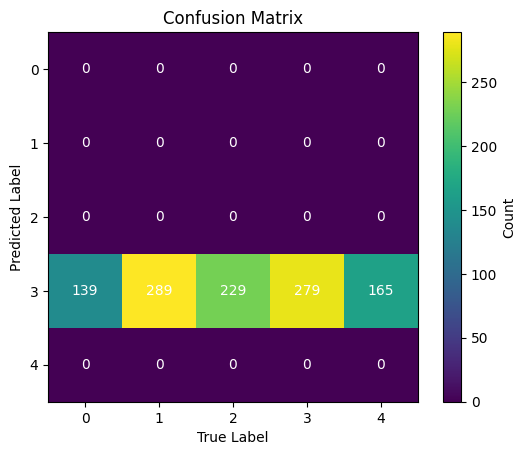

In [95]:
confusion_matrix = confusionMatrix(val_labels, predicted_labels)
plotMatrix(confusion_matrix)

In [96]:
def performance(confusionMatrix):

  n = confusionMatrix.shape[0] #numberOfClasses
  precision = np.zeros(n)
  recall = np.zeros(n)
  f1_score = np.zeros(n)
  for i in range (0,n):
    precision[i] = confusionMatrix[i][i] / np.sum(confusionMatrix[:, i])
    recall[i] = confusionMatrix[i][i] / np.sum(confusionMatrix[i,:])
    f1_score[i] = 2*precision[i]*recall[i] / precision[i] + recall[i]

  macroaveraged_precision = np.sum(precision) / n
  macroaveraged_recall = np.sum(recall) / n
  macroaveraged_f1 = np.sum(f1_score) / n

  return precision, recall, f1_score, macroaveraged_precision, macroaveraged_recall, macroaveraged_f1

In [98]:
precision, recall, f1_score, macroaveraged_precision, macroaveraged_recall, macroaveraged_f1 = performance(confusion_matrix)

<ipython-input-96-b72c8701c960>:9: RuntimeWarning: invalid value encountered in scalar divide
  recall[i] = confusionMatrix[i][i] / np.sum(confusionMatrix[i,:])


In [99]:
for i in range(5):
  print(f"Precision of class {i} is {precision[i]}")
  print(f"Recall of class {i} is {recall[i]}")
  print(f"f1 score of class {i} is {f1_score[i]}")
print(f"Macro averaged percision is {macroaveraged_precision} ")
print(f"Macro averaged recall is {macroaveraged_recall} ")
print(f"Macro averaged f1 score is {macroaveraged_f1} ")

Precision of class 0 is 0.0
Recall of class 0 is nan
f1 score of class 0 is nan
Precision of class 1 is 0.0
Recall of class 1 is nan
f1 score of class 1 is nan
Precision of class 2 is 0.0
Recall of class 2 is nan
f1 score of class 2 is nan
Precision of class 3 is 1.0
Recall of class 3 is 0.25340599455040874
f1 score of class 3 is 0.7602179836512262
Precision of class 4 is 0.0
Recall of class 4 is nan
f1 score of class 4 is nan
Macro averaged percision is 0.2 
Macro averaged recall is nan 
Macro averaged f1 score is nan 


In [100]:
predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)
print(f" Accuracy : {accuracy_score(test_labels, predicted_labels)*100}")

 Accuracy : 23.076923076923077


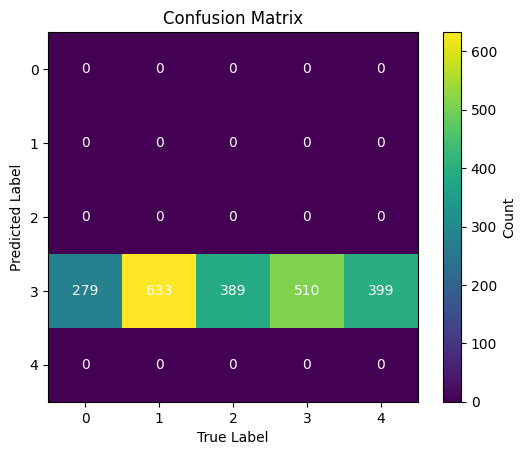

In [101]:
confusion_matrix = confusionMatrix(test_labels, predicted_labels)
plotMatrix(confusion_matrix)

In [103]:
precision, recall, f1_score, macroaveraged_precision, macroaveraged_recall, macroaveraged_f1 = performance(confusion_matrix)

<ipython-input-96-b72c8701c960>:9: RuntimeWarning: invalid value encountered in scalar divide
  recall[i] = confusionMatrix[i][i] / np.sum(confusionMatrix[i,:])


In [104]:
for i in range(5):
  print(f"Precision of class {i} is {precision[i]}")
  print(f"Recall of class {i} is {recall[i]}")
  print(f"f1 score of class {i} is {f1_score[i]}")
print(f"Macro averaged percision is {macroaveraged_precision} ")
print(f"Macro averaged recall is {macroaveraged_recall} ")
print(f"Macro averaged f1 score is {macroaveraged_f1} ")

Precision of class 0 is 0.0
Recall of class 0 is nan
f1 score of class 0 is nan
Precision of class 1 is 0.0
Recall of class 1 is nan
f1 score of class 1 is nan
Precision of class 2 is 0.0
Recall of class 2 is nan
f1 score of class 2 is nan
Precision of class 3 is 1.0
Recall of class 3 is 0.23076923076923078
f1 score of class 3 is 0.6923076923076923
Precision of class 4 is 0.0
Recall of class 4 is nan
f1 score of class 4 is nan
Macro averaged percision is 0.2 
Macro averaged recall is nan 
Macro averaged f1 score is nan 


#SK-learn Model

In [105]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state = 42)
model.fit(train_features, train_labels)

LogisticRegression(random_state=42)

In [106]:
predictions = model.predict(val_features)
print(f" Accuracy : {accuracy_score(val_labels, predictions)*100}")

 Accuracy : 25.340599455040874


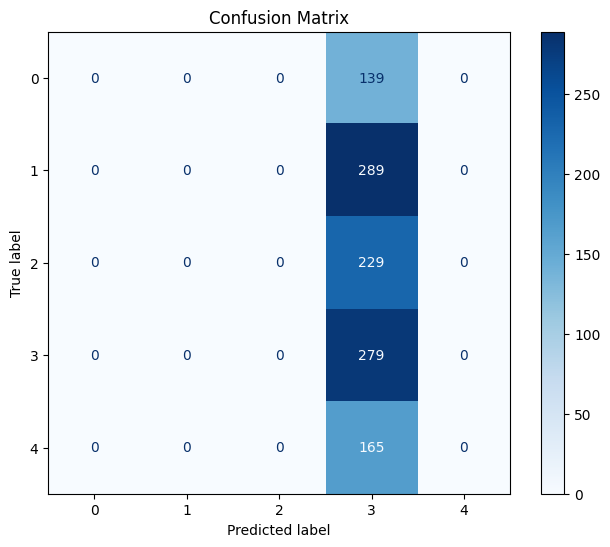

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusionMatrix = confusion_matrix(val_labels, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [108]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(val_labels, predictions, average='macro')  # or 'micro', 'weighted', 'samples', 'macro'
recall = recall_score(val_labels, predictions, average='macro')
f1 = f1_score(val_labels, predictions, average='macro')
print(f"precision: {precision}\n")
print(f"recall: {recall}\n")
print(f"f1_score: {f1}\n")

precision: 0.05068119891008175

recall: 0.2

f1_score: 0.0808695652173913



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
predictions = model.predict(test_features)
print(f" Accuracy : {accuracy_score(test_labels, predictions)*100}")

 Accuracy : 23.076923076923077


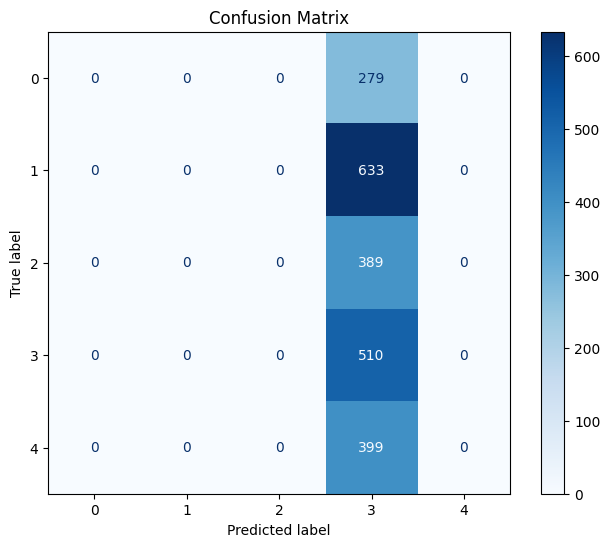

In [111]:
confusionMatrix = confusion_matrix(test_labels, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [112]:
precision = precision_score(test_labels, predictions, average='macro')  # or 'micro', 'weighted', 'samples', 'macro'
recall = recall_score(test_labels, predictions, average='macro')
f1 = f1_score(test_labels, predictions, average='macro')
print(f"precision: {precision}\n")
print(f"recall: {recall}\n")
print(f"f1_score: {f1}\n")

precision: 0.046153846153846156

recall: 0.2

f1_score: 0.075



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
